In [17]:
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd

import warnings
warnings.simplefilter("ignore")

In [2]:
# param_scan:
#Wc=[1]
#psi=[0,1]
#D=[0.1,0.5,0.1]
#ftax=[0]
#sphere_rads = [100, 50, 25, 15]
#file name=Wc__%g__psi__%g__D__%g__ftax__%g__%d_cells_sphere_%d'

In [3]:
#file_path = '/Users/timrudge/cellmodeller/data/param_scan_psi_hd_10x/'
file_path = '../../../cellmodeller/data/'

# Location of the data we want to analyse, assume all folders are results
folders = os.listdir(file_path)

df = pd.DataFrame(columns=['Wc', 'psi', 'D', 'density', 'time', 'max_size', 'mean_size', 'number'])
df_dist = pd.DataFrame(columns=['Wc', 'psi', 'D', 'density', 'time', 'size'])


for folder in folders:
    fname = os.path.join(file_path, folder, 'step-%05d.pickle')
    
    # Extract parameters from folder name
    parts = fname.split('__')
    Wc = float(parts[1].replace('_', '.'))
    psi = float(parts[3].replace('_', '.'))
    D = float(parts[5].replace('_', '.'))
    N = int(parts[8].split('_')[0])
    sphere_rad = float(parts[8].split('_')[3].split('-')[0])
    density = N / (4 * sphere_rad**2)
    
    # Look at the first 1000 time steps of this simulation
    for t in range(0,1000,10):
        # Get the cell states
        data = pickle.load(open(fname%t, 'rb'))
        cs = data['cellStates']
        # Construct a graph with cells as nodes and cell-cell contacts as edges
        G = nx.Graph()
        for id,cell in cs.items():
            for n in cell.neighbours:
                G.add_edge(id, n)
        # Get the sizes of the connected components = clusters
        sizes = [len(c) for c in nx.connected_components(G)]
        if len(sizes)>0:
            # Dominant cluster size
            max_size = np.max(sizes)
            mean_size = np.mean(sizes)
            # Count the number of clusters, including single cells
            number = nx.number_connected_components(G) + N - np.sum(sizes)
            row = {
                'Wc': Wc, 
                'psi':psi,
                'D': D,
                'time':t, 
                'density':density,
                'max_size':max_size, 
                'mean_size':mean_size, 
                'number':number,
            }
            df = df.append(row, ignore_index=True)
            rows = pd.DataFrame()
            rows['size'] = sizes
            rows['Wc'], rows['psi'], rows['D'], rows['time'], rows['density'] = Wc, psi, D, t, density
            df_dist = df_dist.append(rows)

In [ ]:
# param_scan:
#Wc=[1]
#psi=[0,1]
#D=[0.1,0.5,0.1]
#ftax=[0]
#sphere_rads (density) = [100, 50, 25, 15]
#file name=Wc__%g__psi__%g__D__%g__ftax__%g__%d_cells_sphere_%d'

In [ ]:
#group psi, D, sphere_rads = 2*3*4 = 24

### mean_size

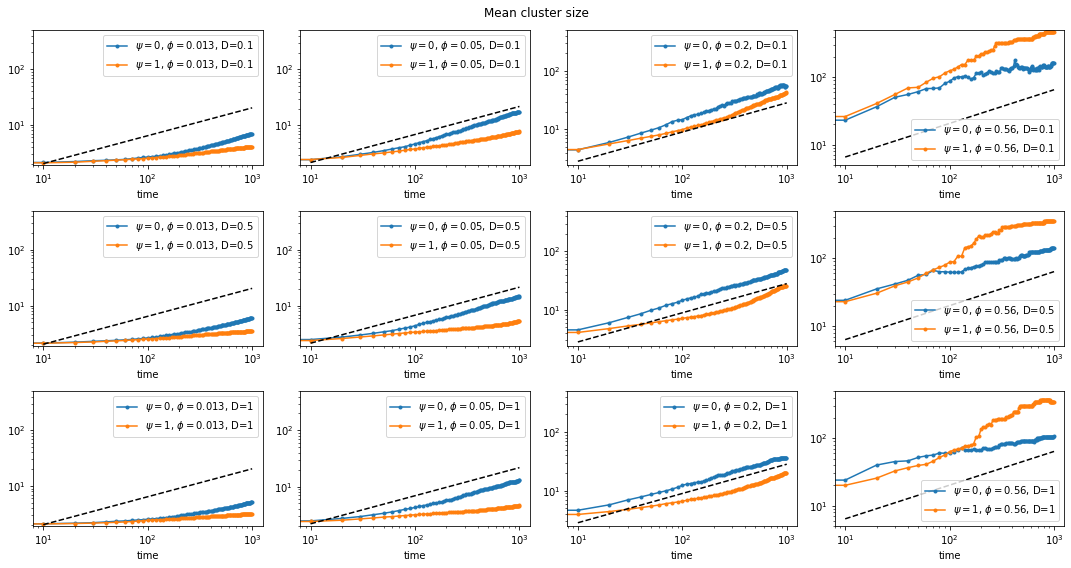

In [18]:
plt.rcParams['figure.figsize'] = 15, 8
fig,axs = plt.subplots(3,4)

i = 0
for D, gg_D in df.groupby('D'):
    for sr, gg_sr in gg_D.groupby('density'):
        legend = []
        for psi, gg_psi in gg_sr.groupby('psi'):            
            mean = gg_psi.sort_values('time').groupby('time').mean()
            mean.plot(y='mean_size', ax=axs[i // 4][i % 4], loglog=True, style='.-')
            legend.append(r'$\psi=%0.2g$, $\phi=%0.2g$, D=%0.2g'%(psi,sr, D))
            #print(f"D: {D}, sr: {sr}, psi: {psi}, ")
        axs[i // 4][i % 4].legend(legend)
        axs[i // 4][i % 4].set_ylim([0,500])
        log_min = np.log10(mean['mean_size'].min())
        axs[i // 4][i % 4].plot([1e1,1e3], [10**log_min, 10**(log_min+3/3)], 'k--')
        i+=1

plt.suptitle('Mean cluster size')
plt.tight_layout()

### max_size

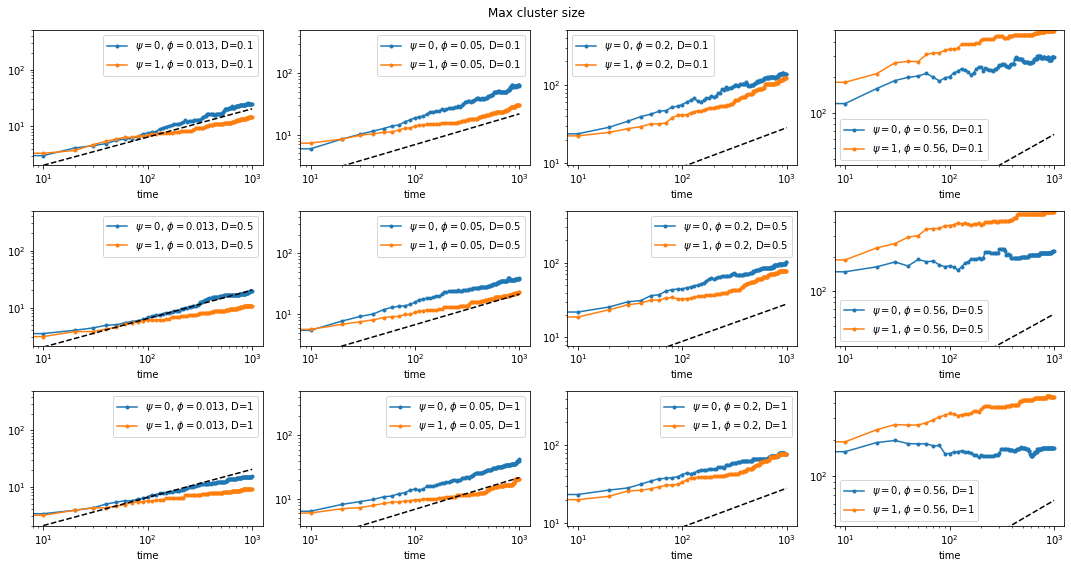

In [19]:
plt.rcParams['figure.figsize'] = 15, 8
fig,axs = plt.subplots(3,4)

i = 0
for D, gg_D in df.groupby('D'):
    for sr, gg_sr in gg_D.groupby('density'):
        legend = []
        for psi, gg_psi in gg_sr.groupby('psi'):            
            mean = gg_psi.sort_values('time').groupby('time').mean()
            mean.plot(y='max_size', ax=axs[i // 4][i % 4], loglog=True, style='.-')
            legend.append(r'$\psi=%0.2g$, $\phi=%0.2g$, D=%0.2g'%(psi,sr, D))
            #print(f"D: {D}, sr: {sr}, psi: {psi}, ")
        axs[i // 4][i % 4].legend(legend)
        axs[i // 4][i % 4].set_ylim([0,500])
        log_min = np.log10(mean['mean_size'].min())
        axs[i // 4][i % 4].plot([1e1,1e3], [10**log_min, 10**(log_min+3/3)], 'k--')
        i+=1

plt.suptitle('Max cluster size')
plt.tight_layout()

### Dists

In [ ]:
gg = df_ld_dist[(df_ld_dist.time==990) * (df_ld_dist.Wc==1) * (df_ld_dist.psi==1) * (df_ld_dist.D==0.1) * (df_ld_dist.density==0.1)]
plt.hist(gg['size'], bins=20, log=True, alpha=0.5)
gg = df_ld_dist[(df_ld_dist.time==990) * (df_ld_dist.Wc==1) * (df_ld_dist.psi==0)]
plt.hist(gg['size'], bins=20, log=True, alpha=0.5)
plt.legend(['$\psi=1$', '$\psi=0$'])

plt.figure()
gg = df_md_dist[(df_md_dist.time==990) * (df_md_dist.Wc==1) * (df_md_dist.psi==1)]
plt.hist(gg['size'], bins=20, log=True, alpha=0.5)
gg = df_md_dist[(df_md_dist.time==990) * (df_md_dist.Wc==1) * (df_md_dist.psi==0)]
plt.hist(gg['size'], bins=20, log=True, alpha=0.5)
plt.legend(['$\psi=1$', '$\psi=0$'])

In [ ]:
df.head()

In [ ]:
df_dist.head()

In [ ]:
df[df.time==990][df.psi==1].sort_values('Wc').plot(x='Wc', y='number', style='-')
df[df.time==990][df.psi==1].sort_values('Wc').plot(x='Wc', y='max_size', style='-')
df[df.time==990][df.psi==1].sort_values('Wc').plot(x='Wc', y='mean_size', style='-')

In [ ]:
dfend = df[df.time==990]
c1,bins1 = pd.cut(dfend.Wc, bins=10, retbins=True)
c2,bins2 = pd.cut(dfend.psi, bins=10, retbins=True) 
hm_number = dfend.groupby([c1, c2]).number.mean().unstack()
hm_max_size = dfend.groupby([c1, c2]).max_size.mean().unstack()
hm_mean_size = dfend.groupby([c1, c2]).mean_size.mean().unstack()

In [ ]:
fig,axs = plt.subplots(2,1, figsize=(5,7))
df_Wc1 = df[df.Wc==1]
grouped = df_Wc1.groupby('psi')
for psi,g in grouped:
    mean = g.sort_values('time').groupby('time').mean()
    mean.plot(y='number', ax=axs[0], loglog=True, style='-.')
    mean.plot(y='mean_size', ax=axs[1], loglog=True, style='-.')
legend = ['$\psi=%0.2g$'%psi for psi,g in grouped]
axs[0].legend([])
axs[1].legend(legend, loc=(1.1,0))
axs[0].plot([1e1,1e3], [10**1.5, 10**(1.5-2/3)], 'k--')
axs[0].set_ylim([1e0,1e2])
axs[1].plot([1e1,1e3], [1e2, 10**(2+2/3)], 'k--')
axs[1].set_ylim([10**1.75,1e3])
plt.tight_layout()